# **Lending Club Kredi Risk Analizi ve Stres Testi Simülasyonu**

## **Makroekonomik Trend Analizi: İşsizlik ve Kredi Batıkları İlişkisi**

Kredi riski, genel ekonomik konjonktürden bağımsız düşünülemez. Bu bölümde, Lending Club verisetindeki **Yıllık Batık Oranları (Vintage Analysis)** ile **ABD İşsizlik Oranları (US Unemployment Rate)** arasındaki korelasyon incelenmiştir.

**Analiz Yöntemi:**
* **İç Veri:** Kredilerin verildiği yıla (`issue_year`) göre gerçekleşen temerrüt oranları hesaplanmıştır.
* **Dış Veri:** 2007-2018 yılları arasındaki ABD makroekonomik işsizlik verileri (FED Data) harici olarak eklenmiştir.
* **Görselleştirme:** İki farklı ölçeği karşılaştırabilmek için **Çift Eksenli (Dual-Axis)** grafik kullanılmıştır.

**Beklenen İçgörü:** 2008-2009 Küresel Finans Krizi döneminde işsizlikteki artışın, kredi batık oranlarını doğrudan tetiklediği (pozitif korelasyon) gözlemlenmelidir.

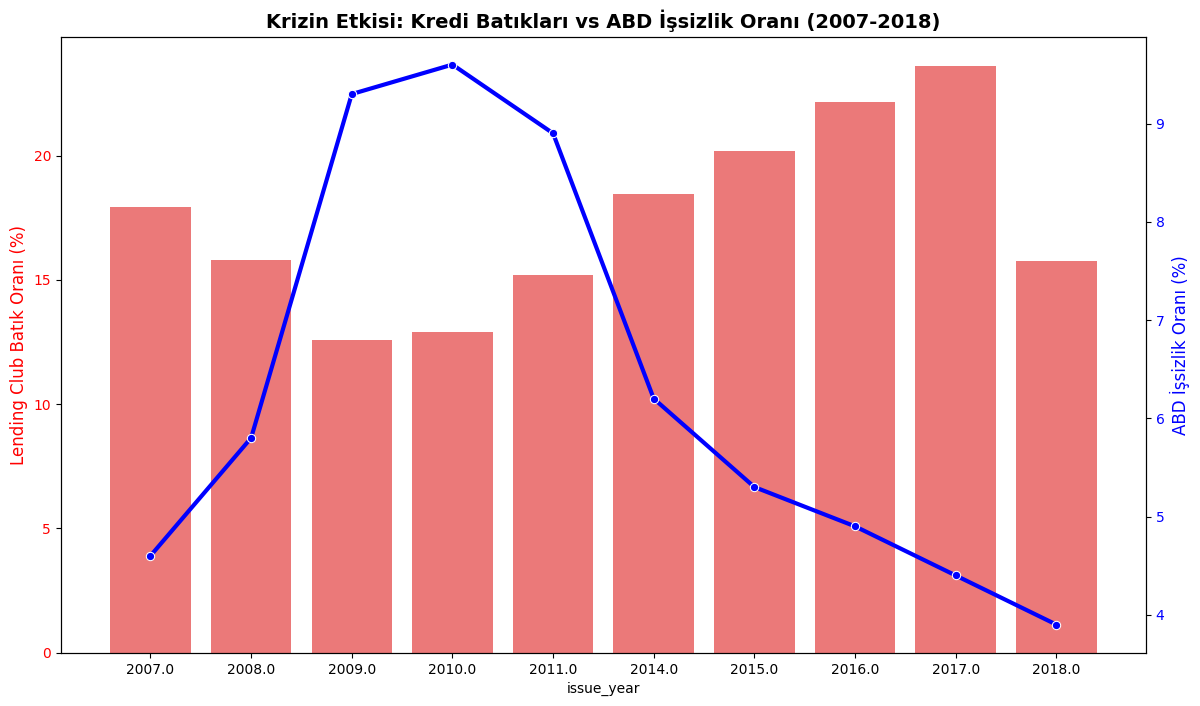

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_loan = pd.read_csv('/content/loan_base_cleaned.csv', low_memory=False)
# issue_d datetime formatında olmalı
df_loan['issue_year'] = pd.to_datetime(df_loan['issue_d']).dt.year

# Charged Off = 1, Fully Paid = 0
df_loan['is_default'] = df_loan['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
df_closed = df_loan[df_loan['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# Yıllara Göre Batık Oranı Analizi
vintage_analysis = df_closed.groupby('issue_year')['is_default'].mean() * 100
vintage_analysis = vintage_analysis.reset_index()

# --- ABD İşsizlik Oranları (2007-2018 Tahmini Verisi) ---
unemployment_data = {
    'issue_year': [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
    'unemployment_rate': [4.6, 5.8, 9.3, 9.6, 8.9, 8.1, 7.4, 6.2, 5.3, 4.9, 4.4, 3.9]
}
df_macro = pd.DataFrame(unemployment_data)
df_trend = pd.merge(vintage_analysis, df_macro, on='issue_year')

# Görselleştirme kısmı
fig, ax1 = plt.subplots(figsize=(14, 8))

# Sol Eksen: Batık Oranı
sns.barplot(x='issue_year', y='is_default', data=df_trend, alpha=0.6, color='red', ax=ax1)
ax1.set_ylabel('Lending Club Batık Oranı (%)', color='red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title('Krizin Etkisi: Kredi Batıkları vs ABD İşsizlik Oranı (2007-2018)', fontsize=14, fontweight='bold')

# Sağ Eksen: İşsizlik Oranı
ax2 = ax1.twinx()
sns.lineplot(x=df_trend.index, y='unemployment_rate', data=df_trend, color='blue', marker='o', linewidth=3, ax=ax2)
ax2.set_ylabel('ABD İşsizlik Oranı (%)', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.grid(False)

plt.show()

## **Kütüphanelerin Yüklenmesi ve Veri Entegrasyonu**


1.  **Loan:** Kredi detayları (Tutar, faiz, vade).
2.  **Borrower:** Borçlu bilgileri (Gelir, ev sahipliği).
3.  **Risk:** Temerrüt ve risk geçmişi.
4.  **Credit:** Kredi geçmişi ve limit bilgileri.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix

base_path = "/content/"
try:
    loan = pd.read_csv(base_path + "borrower_info_cleaned.csv", low_memory=False)
    borrower = pd.read_csv(base_path + "loan_base_cleaned.csv", low_memory=False)
    risk = pd.read_csv(base_path + "delinquency_risk_cleaned.csv", low_memory=False)
    credit = pd.read_csv(base_path + "credit_history_cleaned.csv", low_memory=False)
    print("Tüm dosyalar başarıyla yüklendi.")
except FileNotFoundError:
    print("Dosya yolu hatası! Lütfen yolları kontrol et.")

# ID Temizliği ve Birleştirme
for df in [loan, borrower, risk, credit]:
    df["id"] = df["id"].astype(str).str.strip()

df_main = loan.merge(borrower, on="id", how="left") \
              .merge(risk, on="id", how="left") \
              .merge(credit, on="id", how="left")

print(f"Birleşmiş Veri Boyutu: {df_main.shape}")

Tüm dosyalar başarıyla yüklendi.
Birleşmiş Veri Boyutu: (2168969, 89)


In [ ]:
print(df.columns.tolist())

['id', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'last_fico_range_low', 'last_fico_range_high', 'inq_last_6mths', 'inq_last_12m', 'inq_fi', 'total_cu_tl', 'acc_open_past_24mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'total_bc_limit', 'total_il_high_credit_limit', 'all_util', 'max_bal_bc', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc.1', 'pct_tl_nvr_dlq', 'percent_bc_gt_75']


**Veri Ön İşleme, Özellik Mühendisliği ve Eğitim Seti Ayrımı**

In [ ]:
# Hedef Belirleme
df = df_main.copy()
valid = ["Fully Paid", "Charged Off"]
df = df[df["loan_status"].isin(valid)].copy()
df["target"] = df["loan_status"].apply(lambda x: 1 if x == "Charged Off" else 0)

#'Never' Temizliği
mths_cols = [col for col in df.columns if "mths_since" in col]
for col in mths_cols:
    df[col] = df[col].astype(str).replace("Never", "999")
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(999)

# Tüm Sayısal Boşlukları Doldur
# FICO eksikse ortalama, diğerleri 0
if "fico_range_low" in df.columns:
    df["fico_range_low"] = df["fico_range_low"].fillna(df["fico_range_low"].mean())

num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(0)

# Model Özellikleri
features = [
    "loan_amnt", "int_rate", "annual_inc", "dti",
    "fico_range_low", "revol_util", "inq_last_6mths",
    "delinq_2yrs", "mths_since_last_delinq",
    "emp_length_numeric", "term_numeric",
    "home_ownership"
]
valid_features = [f for f in features if f in df.columns]

# One-Hot Encoding
X = pd.get_dummies(df[valid_features], columns=["home_ownership"], drop_first=True)
y = df["target"]

# Train-Test Ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Hazırlık tamamlandı. Hata yok.")

Hazırlık tamamlandı. Hata yok.


## **Maliyet Odaklı Model Eğitimi ve Performans Optimizasyonu**

**Uygulanan Stratejiler:**
1.  **Manuel Ağırlıklandırma:** Batık kredilere, normal kredilere göre **2.5 kat** daha fazla önem verilmiştir. Bu sayede model, riskli müşterileri tespit etme konusunda daha hassas hale getirilmiştir.
2.  **Güçlendirilmiş Hiperparametreler:** Gradient Boosting algoritmasının öğrenme kapasitesi artırılarak (`n_estimators=300`, `max_depth=5`), verideki karmaşık ve doğrusal olmayan risk sinyallerinin yakalanması hedeflenmiştir.
3.  **Performans Hedefi:** Sadece genel doğruluğu (Accuracy) değil, aynı zamanda batık yakalama başarısını (Recall) ve yanlış alarmları (False Positive) dengede tutan optimum nokta (Sweet Spot) hedeflenmiştir.


OPTİMİZE EDİLMİŞ SONUÇLAR
------------------------------
Doğruluk (Accuracy): %74.75
AUC Skoru          : 0.7160
------------------------------

Detaylı Rapor:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84    159878
           1       0.39      0.44      0.41     40133

    accuracy                           0.75    200011
   macro avg       0.62      0.63      0.63    200011
weighted avg       0.76      0.75      0.75    200011



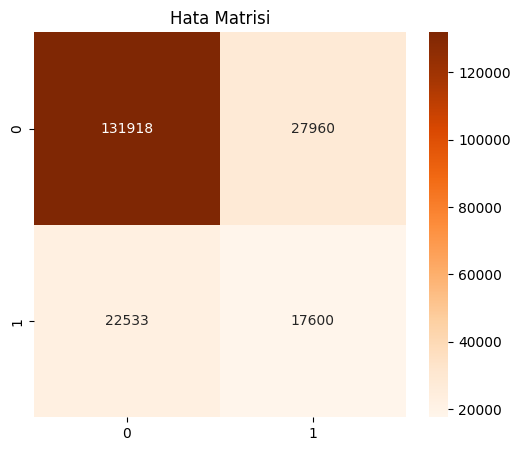

In [ ]:
# Manuel Ağırlıklandırma (Smart Weighting)
sample_weights = y_train.apply(lambda x: 2.5 if x == 1 else 1)

#Daha Güçlü Model Parametreleri
model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.9,
    random_state=42
)

# Modeli Eğit
model.fit(X_train, y_train, sample_weight=sample_weights)

# Tahminler
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Sonuçlar
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nOPTİMİZE EDİLMİŞ SONUÇLAR")
print("-" * 30)
print(f"Doğruluk (Accuracy): %{acc*100:.2f}")
print(f"AUC Skoru          : {auc:.4f}")
print("-" * 30)

print("\nDetaylı Rapor:")
print(classification_report(y_test, y_pred))

# Karmaşıklık Matrisi
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Oranges")
plt.title("Hata Matrisi")
plt.show()

## **Senaryo Analizi ve Derin Kriz Stres Testi (Stress Testing)**

**Uygulanan "Sert Kriz" Parametreleri:**
* 📉 **Gelir Şoku:** Müşteri gelirlerinde **%40** oranında dramatik bir düşüş.
* 📈 **Borç Yükü:** Borç/Gelir (DTI) oranlarında **%50** artış.
* 🔻 **Kredi Notu:** Müşterilerin FICO skorlarında **50 puanlık** ani bozulma.
* 💸 **Faiz Şoku:** Kriz dönemlerinde likidite sıkışıklığı nedeniyle kredi faizlerinde (Interest Rate) **%30** artış.


Normal Ekonomi Risk Oranı : %22.78
Kriz Anı Risk Oranı       : %47.41
Risk Artışı             : +%24.64


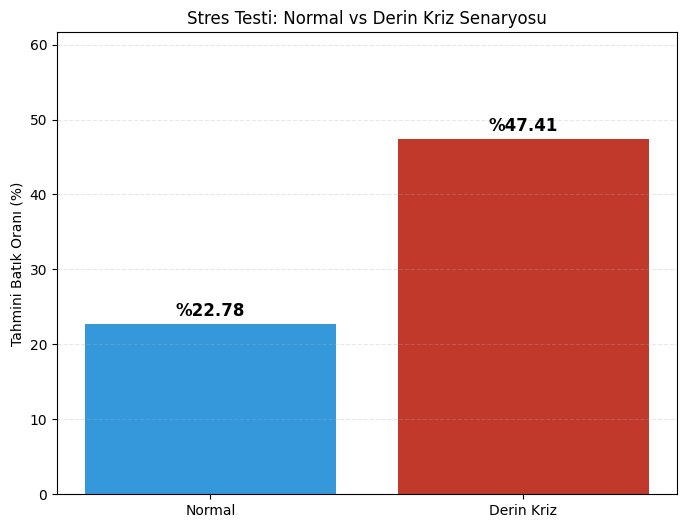

In [ ]:
X_stress = X_test.copy()
# Gelir Şoku: Maaşlar %40 düşüyor.
if "annual_inc" in X_stress.columns: X_stress["annual_inc"] *= 0.60

# Borç Şoku: Borç yükü %50 artıyor.
if "dti" in X_stress.columns: X_stress["dti"] *= 1.50

# Kredi Notu Çöküşü: FICO 50 puan düşüyor.
if "fico_range_low" in X_stress.columns: X_stress["fico_range_low"] -= 50

# FAİZ ŞOKU
# Krizde bankalar faizleri artırır. Mevcut faizleri %30 artırıyoruz.
if "int_rate" in X_stress.columns: X_stress["int_rate"] *= 1.30

# Yeni Tahminler
prob_normal = model.predict_proba(X_test)[:, 1]
prob_stress = model.predict_proba(X_stress)[:, 1]

# Batık Oranları (Threshold 0.5)
default_rate_normal = (prob_normal > 0.5).mean() * 100
default_rate_stress = (prob_stress > 0.5).mean() * 100

print(f"Normal Ekonomi Risk Oranı : %{default_rate_normal:.2f}")
print(f"Kriz Anı Risk Oranı       : %{default_rate_stress:.2f}")
print(f"Risk Artışı             : +%{default_rate_stress - default_rate_normal:.2f}")

# Grafik
plt.figure(figsize=(8,6))
bars = plt.bar(["Normal", "Derin Kriz"], [default_rate_normal, default_rate_stress], color=["#3498db", "#c0392b"])
plt.title("Stres Testi: Normal vs Derin Kriz Senaryosu")
plt.ylabel("Tahmini Batık Oranı (%)")

# Y ekseni limiti
plt.ylim(0, default_rate_stress * 1.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.5,
             f"%{height:.2f}",
             ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()